In [4]:
import pandas as pd
metadata = pd.read_csv('/bigstore/GeneralStorage/Zach/Community_Detection/cell_metadata.csv',index_col = 0)
metadata.head()

,cell_id,cell_type,size,x_coordinate,y_coordinate,z_coordinate,neighbors_10um,neighbors_25um,neighbors_50um,neighbors_100um,neighbors_500um,neighbors_1000um,cell_type_high,cell_type_low
0,0,NaN,232,2489.194641,-3073.888929,5.694537,[],"[1, 63, 97]","[1, 19, 44, 50, 63, 66, 97, 6302, 6335]","[1, 2, 5, 6, 8, 9, 19, 22, 23, 31, 32, 34, 35,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Sst,Sst_1
1,1,NaN,169,2510.851255,-3064.387536,7.297085,[],"[0, 63, 6302]","[0, 2, 19, 63, 83, 97, 6302, 6308, 6317, 6319,...","[0, 2, 9, 19, 23, 34, 35, 36, 38, 41, 43, 44, ...","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Lamp5,Lamp5 Lhx6_4
2,2,NaN,129,2509.595309,-3020.142910,7.017042,[83],"[45, 83]","[1, 19, 36, 45, 83, 89, 2726, 6302, 6306, 6317...","[0, 1, 19, 23, 34, 36, 38, 41, 44, 45, 50, 51,...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Sst,Sst_13
3,3,NaN,4,2405.636693,-3184.088189,6.634682,[],"[37, 53]","[7, 14, 15, 17, 18, 37, 53, 75, 84]","[4, 6, 7, 8, 9, 13, 14, 15, 17, 18, 20, 21, 22...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Vip,Vip_2
4,4,NaN,544,2333.740485,-3154.834995,6.578610,[],"[13, 20, 21, 25, 49, 100]","[13, 15, 20, 21, 25, 26, 27, 30, 49, 55, 81, 9...","[3, 7, 10, 11, 13, 14, 15, 16, 20, 21, 25, 26,...","[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",CA1sp,CA1sp/SUB-sp Kcnip1_2


In [129]:
import numpy as np
import matplotlib.pyplot as plt
x_min = metadata.x_coordinate.min()
x_max = metadata.x_coordinate.max()
y_min = metadata.y_coordinate.min()
y_max = metadata.y_coordinate.max()
ct_metadata = metadata[metadata.cell_type_high=='CA1sp']
# x_bins = np.array(range(int(x_min),int(x_max)+1))
# y_bins = np.array(range(int(y_min),int(y_max)+1))
x_bins = np.linspace(x_min,x_max,int((x_max-x_min)/5))
y_bins = np.linspace(y_min,y_max,int((y_max-y_min)/5))

In [130]:
from scipy.ndimage import gaussian_filter
cell_types = metadata.cell_type_low.unique()
out = np.zeros((len(x_bins)-1,len(y_bins)-1,len(cell_types)))
for i,ct in enumerate(cell_types):
    ct_metadata = metadata[metadata.cell_type_low==ct]
    out[:,:,i] = gaussian_filter(np.histogram2d(ct_metadata.x_coordinate,ct_metadata.y_coordinate,bins=[x_bins,y_bins])[0],5)

In [147]:
from tqdm import tqdm
vectors = []
norm_vectors = []
X = []
Y = []
for x in tqdm(range(out.shape[0])):
    for y in range(out.shape[1]):
        vector = out[x,y,:]
        if np.sum(vector)>0.01:
            X.append(x)
            Y.append(y)
            norm_vector = vector.copy()/np.sum(vector)
            vectors.append(vector)
            norm_vectors.append(norm_vector)

100%|██████████| 799/799 [00:15<00:00, 52.13it/s]


In [148]:
len(vectors)

236366

In [149]:
vector_df = pd.DataFrame(vectors)
norm_vector_df = pd.DataFrame(norm_vectors)

In [150]:
from sklearn.decomposition import PCA
pca_df = PCA(n_components=10)
pca_df.fit(norm_vector_df.T)


PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

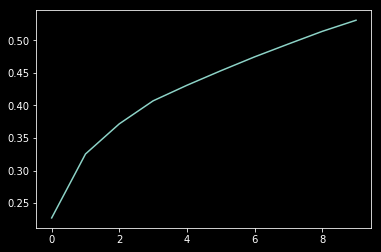

In [151]:
plt.plot(range(0,len(pca_df.explained_variance_ratio_)),np.cumsum(pca_df.explained_variance_ratio_))
plt.show()

In [152]:
import umap

In [153]:
import umap
reducer = umap.UMAP()
import random
v = random.sample(list(range(len(pca_df.components_.T))),5000)
embedding = reducer.fit_transform(pca_df.components_.T[v,:])
embedding.shape

(5000, 2)

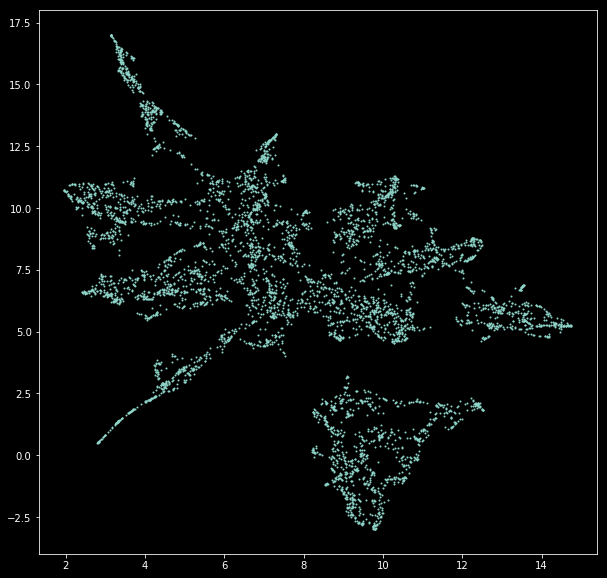

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(embedding[:,0],embedding[:,1],s=1)
plt.show()

In [155]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10,random_state=0).fit(pca_df.components_.T)
len(kmeans.labels_)

236366

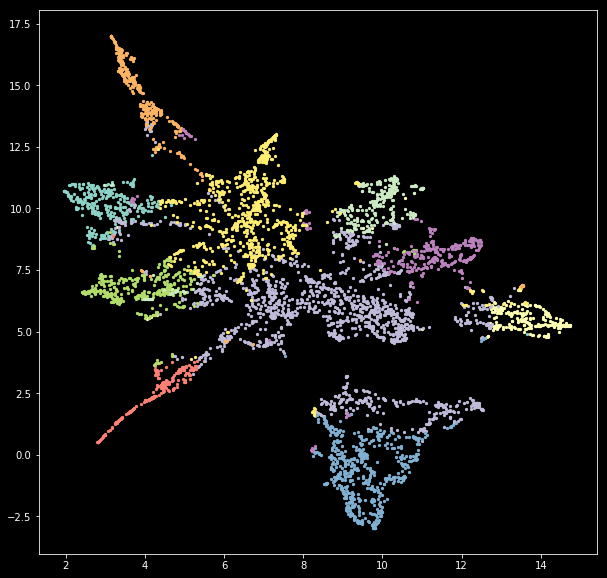

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
cell_types = np.unique(kmeans.labels_)
# random.shuffle(cell_types)
labels = kmeans.labels_[v]
for ct in cell_types:
    mask = labels==ct
    plt.scatter(embedding[mask,0],embedding[mask,1],s=5)
plt.show()

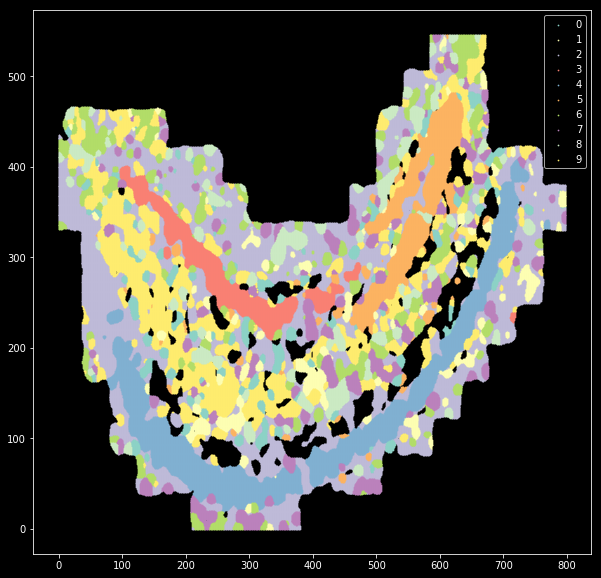

In [166]:
from fish_helpers import *
from tqdm import tqdm
import random
X = np.array(X)
Y = np.array(Y)
plt.figure(figsize=[10,10])
cell_types = np.unique(kmeans.labels_)
# random.shuffle(cell_types)
for l in cell_types:
    mask = kmeans.labels_==l
    plt.scatter(X[mask],Y[mask],s=0.5,label=l,alpha=1)
plt.legend()
plt.show()

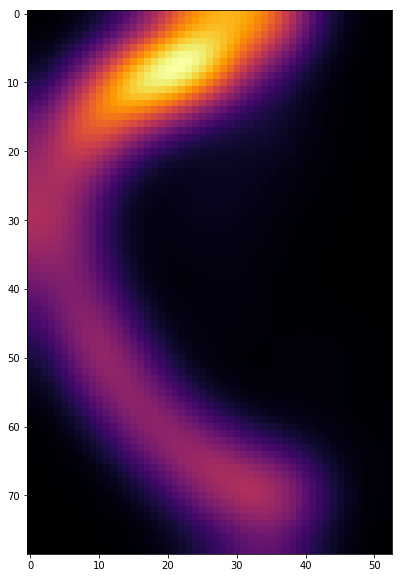

In [24]:
from scipy.ndimage import gaussian_filter
plt.figure(figsize=[10,10])
plt.imshow(np.sum(out,axis=2),cmap='inferno')
plt.show()